<Figure size 640x480 with 0 Axes>

TypeError: Image data of dtype object cannot be converted to float

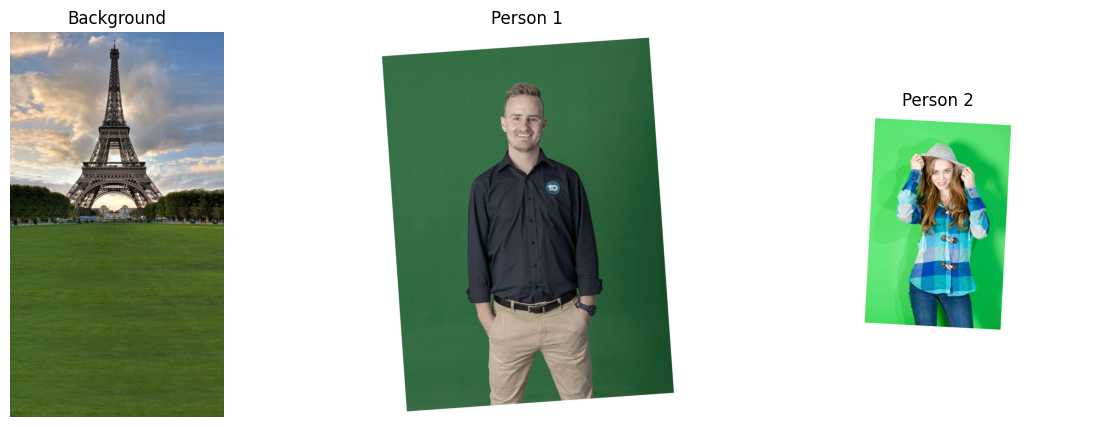

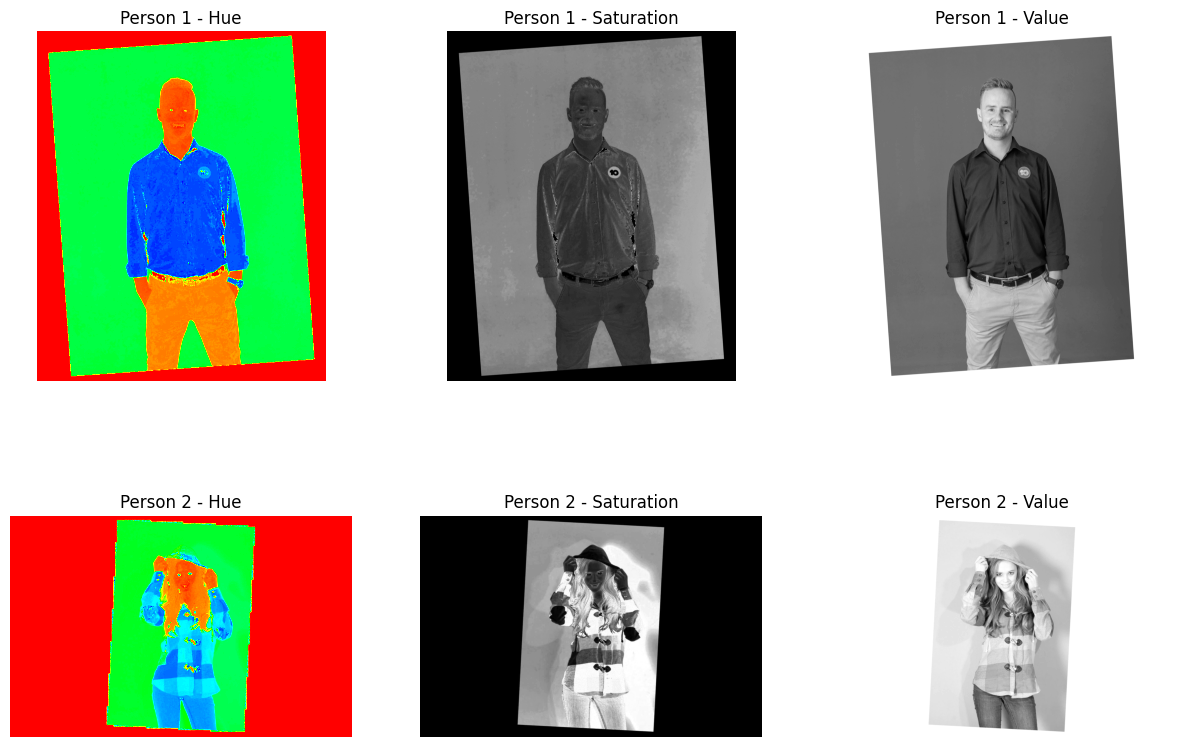

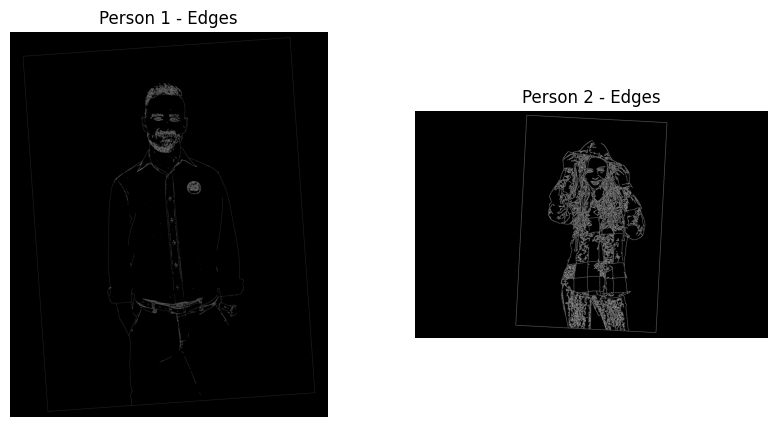

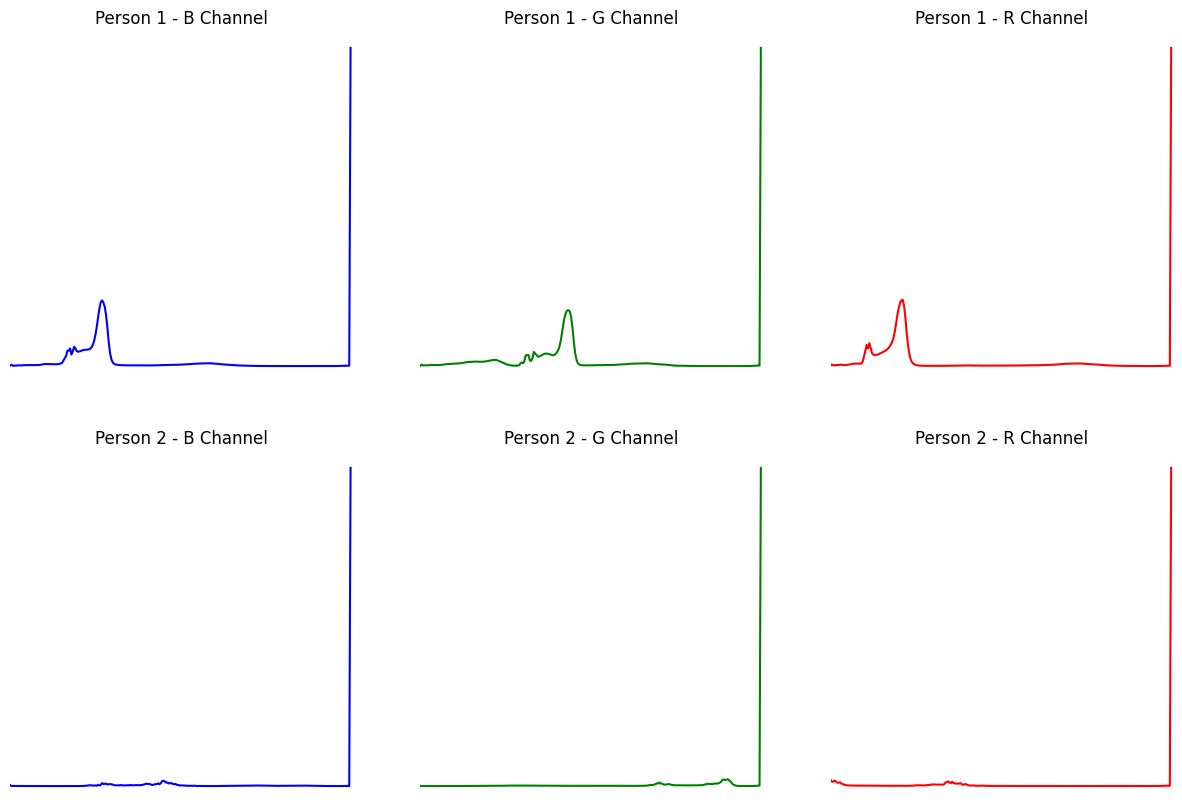

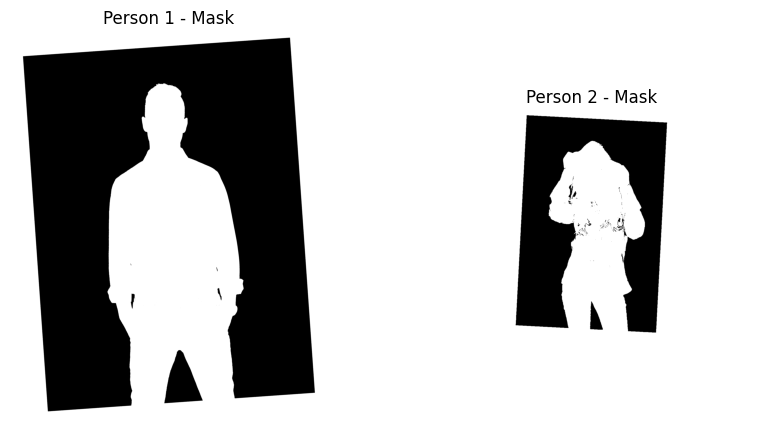

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded


def process_image(BG: np.ndarray, I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    """Remove the following text
    Include your documentation here. 
    Carry out all of your image processing in this function. 
    Please do not change the function signature. 
    Any processing done outside this function will not be graded"""

    """
    Instructions
    Treasured Memories

    Newlyweds John and Jane Doe had to cancel their planned honeymoon to Paris as Jane was too busy with work. Gutted to miss out on a family portrait in front of the Eiffel Tower, they've asked you to help. Both have sent you portraits of themselves and the background they'd like to use for this portrait. Use your newfound image processing skills to write a python programme which will re-unite John and Jane in front of the Eiffel Tower.

    Design Specifications:
    Your final design should be a single Jupyter Notebook (using the template provided and adhering to the restrictions within) which, when run, will add human models in two specified photos into a specified background photo. You may assume that the model photos will contain a white border, and be taken in front of a green screen (as in the test images)
    The final image should be an enhanced version of the originals, with similar colour saturation on each of the models, and each model image rotated so that they are perpendicular.
    Your user interface should be simple. It should read in the attached and output a single image. This script should run non-interactively (without requiring the input of a user)
    Your submission be named StudentNumber_Assignment2.ipynb with the text StudentNumber replaced by your actual student number. If your student number is C12345678 then your submission should be named C12345678_Assignment2.ipynb
    Follow the submission guidelines in the attached Jupyter notebook
    Tips (not required):

    In analysing the photos, you notice that person1.jpg is rotated by 3 degrees clockwise and person2.jpg is rotated by -2 degrees anti-clockwise. You may choose to use this as a starting point but please note that your final submission should be able to identify the angle of rotation of any similar image
    Convert to an appropriate colourspace to explore the relative saturation levels of both models
    Enhance the images to increase contrast and definition
    Test for improvements by viewing the image histograms and look for any changes across rows and columns
    The final submission should not contain any interactive elements, but things like cv2.imshow can be useful to investigate the image. Feel free to use these elements while developing your solution, but ensure they are removed before submission.
    """


    def show_results_during_development(BG, I1, I2, mode='original'):
        """
        Visualize images during development with multiple modes for debugging.
        
        Args:
            BG, I1, I2: Input images
            mode: Visualization mode ('original', 'hsv', 'edges', 'histograms', 'masks')
        """
        if mode == 'original':
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(cv2.cvtColor(BG, cv2.COLOR_BGR2RGB))
            ax[1].imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
            ax[2].imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
            ax[0].set_title('Background')
            ax[1].set_title('Person 1')
            ax[2].set_title('Person 2')
            
        elif mode == 'hsv':
            fig, ax = plt.subplots(2, 3, figsize=(15, 10))
            
            # Convert to HSV and split channels
            for i, (img, title) in enumerate([(I1, 'Person 1'), (I2, 'Person 2')]):
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                h, s, v = cv2.split(hsv)
                
                ax[i, 0].imshow(h, cmap='hsv')
                ax[i, 0].set_title(f'{title} - Hue')
                ax[i, 1].imshow(s, cmap='gray')
                ax[i, 1].set_title(f'{title} - Saturation')
                ax[i, 2].imshow(v, cmap='gray')
                ax[i, 2].set_title(f'{title} - Value')
                
        elif mode == 'edges':
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            for i, (img, title) in enumerate([(I1, 'Person 1'), (I2, 'Person 2')]):
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                edges = cv2.Canny(gray, 50, 150)
                ax[i].imshow(edges, cmap='gray')
                ax[i].set_title(f'{title} - Edges')
                
        elif mode == 'histograms':
            fig, ax = plt.subplots(2, 3, figsize=(15, 10))
            
            for i, (img, title) in enumerate([(I1, 'Person 1'), (I2, 'Person 2')]):
                colors = ('b', 'g', 'r')
                for j, color in enumerate(colors):
                    hist = cv2.calcHist([img], [j], None, [256], [0, 256])
                    ax[i, j].plot(hist, color=color)
                    ax[i, j].set_title(f'{title} - {color.upper()} Channel')
                    ax[i, j].set_xlim([0, 256])
                    
        elif mode == 'masks':
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            for i, (img, title) in enumerate([(I1, 'Person 1'), (I2, 'Person 2')]):
                # Create green mask
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                lower_green = np.array([35, 50, 50])
                upper_green = np.array([85, 255, 255])
                mask = cv2.inRange(hsv, lower_green, upper_green)
                mask = cv2.bitwise_not(mask)
                
                ax[i].imshow(mask, cmap='gray')
                ax[i].set_title(f'{title} - Mask')
        
        for a in ax.flat:
            a.axis('off')
    
    plt.tight_layout()
    plt.show()

    show_results_during_development(BG, I1, I2, mode='original')
    show_results_during_development(BG, I1, I2, mode='hsv')
    show_results_during_development(BG, I1, I2, mode='edges')
    show_results_during_development(BG, I1, I2, mode='histograms')
    show_results_during_development(BG, I1, I2, mode='masks')

def process_portraits(I1, I2):
        """
        Process two portrait images to match their color and contrast.
        Returns both processed images and their masks.
        """
        def create_green_mask(image):
            # Convert to HSV (better for color segmentation than RGB)
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            
            # Green screen range (adjust these based on your histograms)
            lower_green = np.array([40, 40, 40])
            upper_green = np.array([80, 255, 255])
            
            # Create mask and clean it up
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = cv2.bitwise_not(mask)  # Invert so person is white, background black
            
            # Clean up mask with morphological operations
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            
            return mask

        def match_histograms(source, reference, mask):
            # Match each channel separately
            matched = source.copy()
            for i in range(3):  # For each RGB channel
                # Calculate histograms for source and reference
                src_hist = cv2.calcHist([source], [i], mask, [256], [0,256])
                ref_hist = cv2.calcHist([reference], [i], None, [256], [0,256])
                
                # Calculate cumulative distribution functions
                src_cdf = src_hist.cumsum()
                ref_cdf = ref_hist.cumsum()
                
                # Normalize CDFs
                src_cdf_normalized = src_cdf / src_cdf[-1]
                ref_cdf_normalized = ref_cdf / ref_cdf[-1]
                
                # Create lookup table
                lookup_table = np.zeros(256)
                j = 0
                for idx in range(len(lookup_table)):
                    while j < len(ref_cdf_normalized) and ref_cdf_normalized[j] < src_cdf_normalized[idx]:
                        j += 1
                    lookup_table[idx] = j
                
                # Apply lookup table to the channel
                matched[:,:,i] = cv2.LUT(source[:,:,i], lookup_table.astype('uint8'))
            
            return matched

        def enhance_contrast(image, mask):
            # Convert to LAB color space (L channel controls lightness)
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            
            # Apply CLAHE to L channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            
            # Merge back and convert to BGR
            lab = cv2.merge([l, a, b])
            enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            
            # Only apply enhancement where mask is non-zero
            return cv2.bitwise_and(enhanced, image, mask=mask)

        # 1. Create masks for both images
        mask1 = create_green_mask(I1)
        mask2 = create_green_mask(I2)
        
        # 2. Enhance contrast of both images
        I1_enhanced = enhance_contrast(I1, mask1)
        I2_enhanced = enhance_contrast(I2, mask2)
        
        # 3. Match I2's histogram to I1 (since I1 has better contrast)
        I2_matched = match_histograms(I2_enhanced, I1_enhanced, mask2)
        
        return I1_enhanced, I2_matched, mask1, mask2

# Function to visualize results at each step
def visualize_processing_steps(I1, I2):
    I1_enhanced, I2_matched, mask1, mask2 = process_portraits(I1, I2)
    
    plt.figure(figsize=(15, 10))
    
    # Original images
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
    plt.title('Person 1 - Original')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
    plt.title('Person 2 - Original')
    plt.axis('off')
    
    # Masks
    plt.subplot(2, 3, 2)
    plt.imshow(mask1, cmap='gray')
    plt.title('Person 1 - Mask')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(mask2, cmap='gray')
    plt.title('Person 2 - Mask')
    plt.axis('off')
    
    # Processed images
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(I1_enhanced, cv2.COLOR_BGR2RGB))
    plt.title('Person 1 - Enhanced')
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(I2_matched, cv2.COLOR_BGR2RGB))
    plt.title('Person 2 - Matched & Enhanced')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    

    # Process portraits first
    I1_processed, I2_processed, mask1, mask2 = process_portraits(I1, I2)

    # Blend into background
    final_image = blend_images(BG, I1_processed, I2_processed, mask1, mask2)

    return final_image.astype(np.uint8)




def blend_images(BG, I1, I2, mask1, mask2):
    """
    Blend two portrait images into a background image with smooth edges.
    
    Args:
        BG: Background image
        I1, I2: Processed portrait images
        mask1, mask2: Masks for the portraits
    """
    # Create a copy of background to work with
    result = BG.copy()
    
    # Resize portraits if needed (adjust scale factors as needed)
    scale1 = 0.8  # Example scale factor for person 1
    scale2 = 0.8  # Example scale factor for person 2
    
    h1, w1 = I1.shape[:2]
    h2, w2 = I2.shape[:2]
    
    new_h1 = int(h1 * scale1)
    new_w1 = int(w1 * scale1)
    new_h2 = int(h2 * scale2)
    new_w2 = int(w2 * scale2)
    
    I1_resized = cv2.resize(I1, (new_w1, new_h1))
    mask1_resized = cv2.resize(mask1, (new_w1, new_h1))
    I2_resized = cv2.resize(I2, (new_w2, new_h2))
    mask2_resized = cv2.resize(mask2, (new_w2, new_h2))
    
    # Calculate positions (adjust these values to position the people)
    bg_h, bg_w = BG.shape[:2]
    
    # Position for person 1 (left side)
    x1 = bg_w // 4 - new_w1 // 2
    y1 = bg_h - new_h1
    
    # Position for person 2 (right side)
    x2 = (3 * bg_w) // 4 - new_w2 // 2
    y2 = bg_h - new_h2
    
    # Create a feathered mask for smooth blending
    def feather_mask(mask, feather_amount=5):
        kernel = np.ones((feather_amount, feather_amount), np.uint8)
        feathered = cv2.GaussianBlur(mask, (feather_amount*2+1, feather_amount*2+1), 0)
        return feathered

    # Feather the masks
    mask1_feathered = feather_mask(mask1_resized)
    mask2_feathered = feather_mask(mask2_resized)
    
    # Blend the images
    for i in range(3):  # For each RGB channel
        # Create a region of interest (ROI) for each person
        roi1 = result[y1:y1+new_h1, x1:x1+new_w1, i]
        roi2 = result[y2:y2+new_h2, x2:x2+new_w2, i]
        
        # Blend the images using the feathered masks
        roi1[:] = roi1 * (1 - mask1_feathered) + I1_resized[:,:,i] * mask1_feathered
        roi2[:] = roi2 * (1 - mask2_feathered) + I2_resized[:,:,i] * mask2_feathered

    
    return result

# Function to visualize the blending process
def visualize_blending(BG, I1, I2):
    # First process the portraits
    I1_processed, I2_processed, mask1, mask2 = process_portraits(I1, I2)
    
    # Then blend them
    final_result = blend_images(BG, I1_processed, I2_processed, mask1, mask2)
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(BG, cv2.COLOR_BGR2RGB))
    plt.title('Original Background')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title('Final Composite')
    plt.axis('off')
    
    # Show a zoomed portion to check blending
    y_zoom = final_result.shape[0] - 300  # Adjust these values
    x_zoom = final_result.shape[1]//4     # to zoom where needed
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(final_result[y_zoom:, x_zoom:x_zoom+300], cv2.COLOR_BGR2RGB))
    plt.title('Zoom on Blend Area')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    
    # Process portraits first
    I1_processed, I2_processed, mask1, mask2 = process_portraits(I1, I2)

    # Blend into background
    final_image = blend_images(BG, I1_processed, I2_processed, mask1, mask2)

    # Or use the visualization function
    visualize_blending(BG, I1, I2)

    return final_image
    

# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function


BG = cv2.imread('./background.jpg')
I1 = cv2.imread('./male.jpg')
I2 = cv2.imread('./female.jpg')

merged = process_image(BG, I1, I2)

plt.imshow(merged)
plt.axis('off')
plt.show()
